<a href="https://colab.research.google.com/github/ohdayoung0/AI_Task/blob/main/week_12/LAB_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


In [2]:
# Load California Housing dataset
data = fetch_california_housing()

# Extract features and target
X = data.data
y = data.target

print("Dataset Information:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {data.feature_names}")
print(f"Target: Median house value (in $100,000s)")

# Display statistics
print(f"\nTarget statistics:")
print(f"  Min: ${y.min() * 100000:.2f}")
print(f"  Max: ${y.max() * 100000:.2f}")
print(f"  Mean: ${y.mean() * 100000:.2f}")

Dataset Information:
Number of samples: 20640
Number of features: 8

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median house value (in $100,000s)

Target statistics:
  Min: $14999.00
  Max: $500001.00
  Mean: $206855.82


In [3]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize features using StandardScaler
# This helps neural networks train faster and more stably
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data normalized (mean=0, std=1)")

Training set size: 16512 samples
Test set size: 4128 samples

✓ Data normalized (mean=0, std=1)


In [4]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Batch size: 64
Number of training batches: 258
Number of test batches: 65


In [5]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32):
        super(RegressionModel, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize model
input_size = X_train_scaled.shape[1]  # Number of features (8)
model = RegressionModel(input_size).to(device)

print(model)
print(f"\nModel moved to: {device}")

RegressionModel(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Model moved to: cuda


In [6]:
# Loss function: Mean Squared Error
criterion = nn.MSELoss()

# Optimizer: Adam with learning rate 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


In [7]:
# Training parameters
num_epochs = 100

# Track losses for visualization
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1. Forward pass: compute predictions
        predictions = model(X_batch)

        # 2. Compute loss
        loss = criterion(predictions, y_batch)

        # 3. Backward pass: compute gradients
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute new gradients

        # 4. Update weights
        optimizer.step()

        train_loss += loss.item()

    # Average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase (no gradient computation needed)
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}")

print("-" * 60)
print("Training complete!")

Starting training...
------------------------------------------------------------
Epoch [10/100] | Train Loss: 0.3203 | Test Loss: 0.3235
Epoch [20/100] | Train Loss: 0.2904 | Test Loss: 0.3036
Epoch [30/100] | Train Loss: 0.2752 | Test Loss: 0.3040
Epoch [40/100] | Train Loss: 0.2681 | Test Loss: 0.2858
Epoch [50/100] | Train Loss: 0.2598 | Test Loss: 0.2819
Epoch [60/100] | Train Loss: 0.2544 | Test Loss: 0.2866
Epoch [70/100] | Train Loss: 0.2516 | Test Loss: 0.2816
Epoch [80/100] | Train Loss: 0.2454 | Test Loss: 0.2720
Epoch [90/100] | Train Loss: 0.2426 | Test Loss: 0.2804
Epoch [100/100] | Train Loss: 0.2378 | Test Loss: 0.2728
------------------------------------------------------------
Training complete!


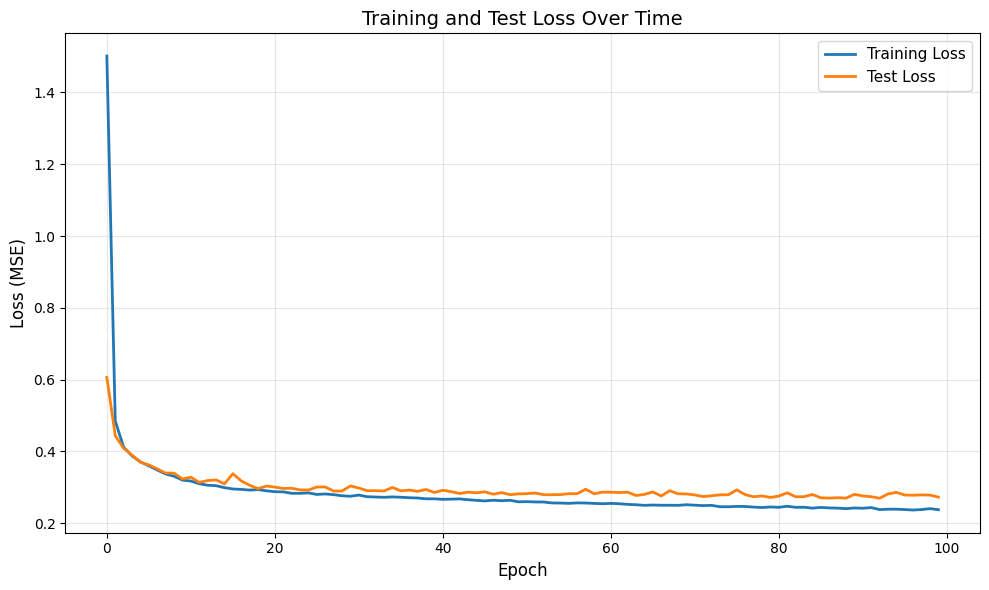

Final Training Loss: 0.2378
Final Test Loss: 0.2728


In [8]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Test Loss Over Time', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

In [9]:
# Make predictions on test set
model.eval()
with torch.no_grad():
    X_test_device = X_test_tensor.to(device)
    y_pred = model(X_test_device).cpu().numpy()
    y_true = y_test_tensor.numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)
print(f"\nInterpretation:")
print(f"On average, predictions are off by ${mae * 100000:.2f}")
print(f"Model explains {r2*100:.2f}% of the variance in house prices")

Model Performance on Test Set:
Mean Squared Error (MSE):  0.2733
Root Mean Squared Error (RMSE): 0.5227
Mean Absolute Error (MAE): 0.3569
R² Score: 0.7915

Interpretation:
On average, predictions are off by $35689.19
Model explains 79.15% of the variance in house prices


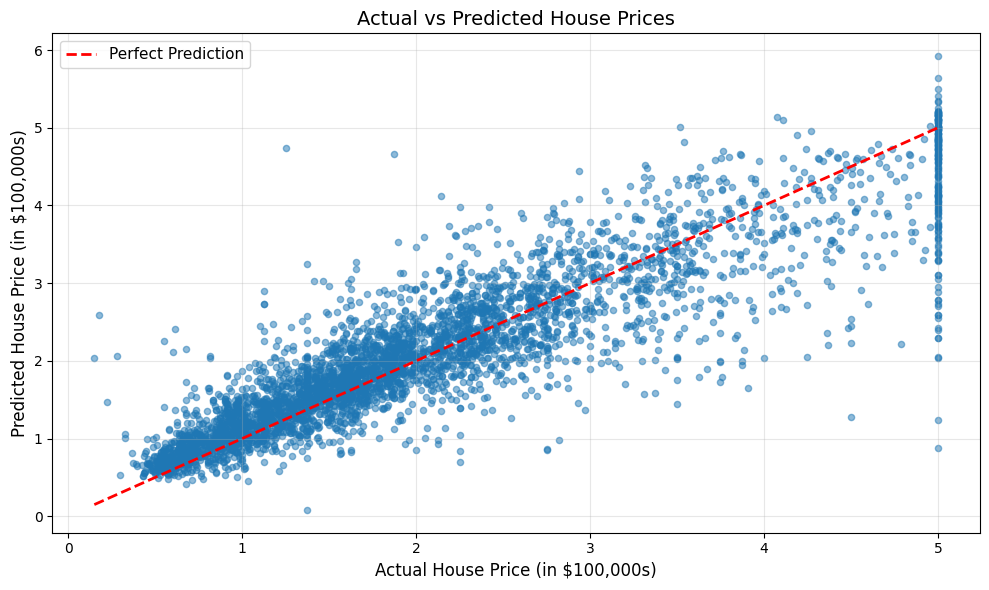


Sample Predictions (first 10 houses):
------------------------------------------------------------
      Actual |    Predicted |   Difference
------------------------------------------------------------
$    47,700 | $    58,942 | $   -11,242
$    45,800 | $    73,624 | $   -27,824
$   500,001 | $   460,492 | $    39,509
$   218,600 | $   245,022 | $   -26,422
$   278,000 | $   292,612 | $   -14,612
$   158,700 | $   171,338 | $   -12,638
$   198,200 | $   235,478 | $   -37,278
$   157,500 | $   175,265 | $   -17,765
$   340,000 | $   236,978 | $   103,022
$   446,600 | $   466,467 | $   -19,867


In [10]:
# Create scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, s=20)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Price (in $100,000s)', fontsize=12)
plt.ylabel('Predicted House Price (in $100,000s)', fontsize=12)
plt.title('Actual vs Predicted House Prices', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some sample predictions
print("\nSample Predictions (first 10 houses):")
print("-" * 60)
print(f"{'Actual':>12} | {'Predicted':>12} | {'Difference':>12}")
print("-" * 60)
for i in range(min(10, len(y_true))):
    actual = y_true[i][0] * 100000
    predicted = y_pred[i][0] * 100000
    diff = actual - predicted
    print(f"${actual:>10,.0f} | ${predicted:>10,.0f} | ${diff:>10,.0f}")

In [11]:
# Save model
torch.save(model.state_dict(), 'house_price_model.pth')
print("✓ Model saved to 'house_price_model.pth'")

# To load the model later:
# model = RegressionModel(input_size)
# model.load_state_dict(torch.load('house_price_model.pth'))
# model.to(device)
# model.eval()

print("\nTo load this model later, use:")
print("  model = RegressionModel(input_size)")
print("  model.load_state_dict(torch.load('house_price_model.pth'))")
print("  model.to(device)")
print("  model.eval()")

✓ Model saved to 'house_price_model.pth'

To load this model later, use:
  model = RegressionModel(input_size)
  model.load_state_dict(torch.load('house_price_model.pth'))
  model.to(device)
  model.eval()


In [12]:
!unzip archive.zip

Archive:  archive.zip
  inflating: housing.csv             


In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 1. 데이터 로드 및 이상치 제거
df = pd.read_csv('housing.csv').dropna()

df = df[df['median_house_value'] < 500000]

# 입력(X)과 정답(y) 분리
X = df.drop(['median_house_value', 'ocean_proximity'], axis=1).values
y = df['median_house_value'].values.reshape(-1, 1)

# 학습용/테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. X와 y 모두 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# PyTorch 텐서 변환
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

# 3. 모델 정의
class AdvancedModel(nn.Module):
    def __init__(self, input_size):
        super(AdvancedModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model = AdvancedModel(X_train_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# 4. 모델 학습
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 5. 결과 확인 (다시 원래 단위로 복구해서 계산)
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()
    # 정규화했던 y값을 다시 실제 달러 단위로 복구합니다.
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    final_r2 = r2_score(y_test, y_pred)
    print(f"\n==============================")
    print(f"(R2 Score): {final_r2:.4f}")
    print(f"==============================")

Epoch [100/500], Loss: 0.2656
Epoch [200/500], Loss: 0.2269
Epoch [300/500], Loss: 0.2122
Epoch [400/500], Loss: 0.2060
Epoch [500/500], Loss: 0.1955

(R2 Score): 0.7692


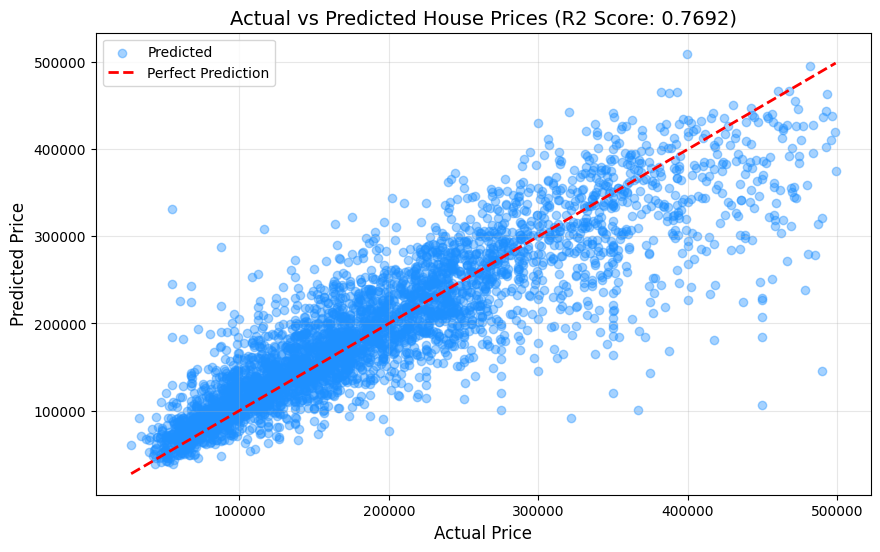


[예측 샘플 (실제값 vs 예측값)]
실제 가격: $73,800 | 예측 가격: $90,845
실제 가격: $359,100 | 예측 가격: $351,113
실제 가격: $94,700 | 예측 가격: $89,602
실제 가격: $238,200 | 예측 가격: $251,597
실제 가격: $49,000 | 예측 가격: $52,169


In [25]:
import matplotlib.pyplot as plt

# 실제값과 예측값 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='dodgerblue', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.title(f'Actual vs Predicted House Prices (R2 Score: {final_r2:.4f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 샘플 결과 출력
print("\n[예측 샘플 (실제값 vs 예측값)]")
for i in range(5):
    print(f"실제 가격: ${y_test[i][0]:,.0f} | 예측 가격: ${y_pred[i][0]:,.0f}")

In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# 1. 데이터 로드 및 고도화된 전처리
df = pd.read_csv('housing.csv').dropna()
df = df[df['median_house_value'] < 500000] # 이상치 제거

# [전략 1] 새로운 특성 생성 (Feature Engineering)
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

# [전략 2] 범주형 데이터 처리 (One-Hot Encoding)
df = pd.get_dummies(df, columns=['ocean_proximity'])

# 데이터 분리
X = df.drop(['median_house_value'], axis=1).values
y = df['median_house_value'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 텐서 변환
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

# [전략 3] 더 정교한 신경망 설계
class FinalUltimateModel(nn.Module):
    def __init__(self, input_size):
        super(FinalUltimateModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1), # ReLU보다 조금 더 유연한 활성화 함수
            nn.Dropout(0.1),    # 과적합 방지
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = FinalUltimateModel(X_train_scaled.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion = nn.MSELoss()

# 학습
epochs = 800
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss) # 손실에 따라 학습률 조절

# 최종 평가
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    final_r2 = r2_score(y_test, y_pred)
    print(f"\n최종 R2 Score: {final_r2:.4f}")


최종 R2 Score: 0.7872


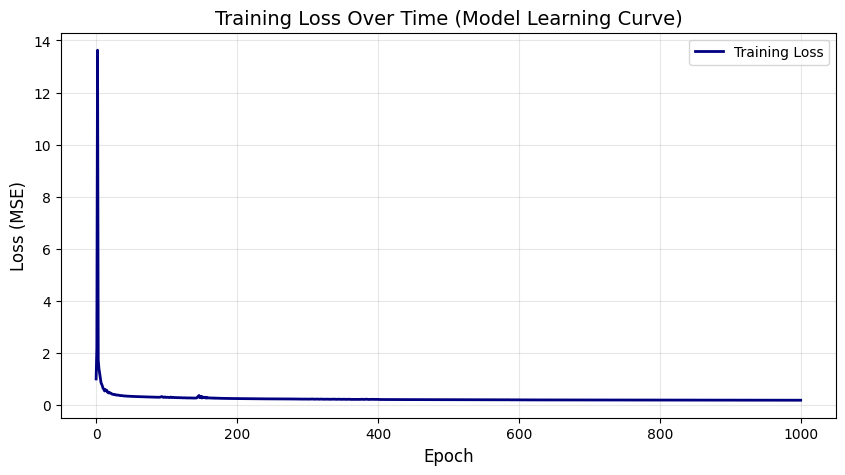

Final Training Loss: 0.1690


In [27]:
import matplotlib.pyplot as plt

# 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='navy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss Over Time (Model Learning Curve)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.4f}")

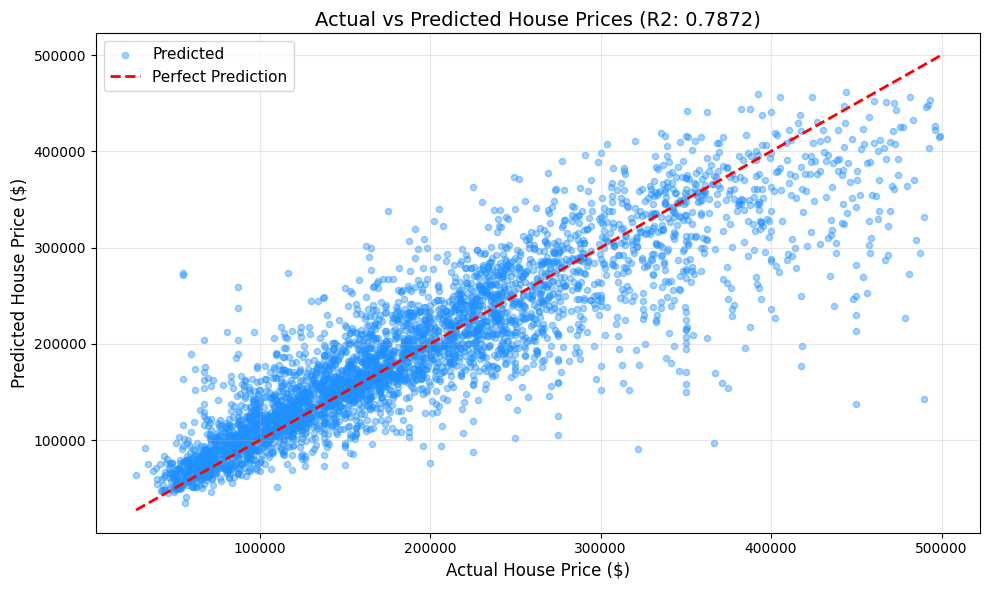


Sample Predictions (Actual vs Predicted):
------------------------------------------------------------
         Actual |       Predicted |      Difference
------------------------------------------------------------
$        73,800 | $        98,161 | $       -24,361
$       359,100 | $       335,824 | $        23,276
$        94,700 | $        91,471 | $         3,229
$       238,200 | $       251,494 | $       -13,294
$        49,000 | $        61,368 | $       -12,368
$       151,400 | $       148,280 | $         3,120
$        92,900 | $       113,902 | $       -21,002
$       450,000 | $       342,671 | $       107,329
$        74,500 | $        90,822 | $       -16,322
$       267,000 | $       216,162 | $        50,838


/tmp/ipython-input-1259197318.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual = float(y_true[i])
/tmp/ipython-input-1259197318.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted = float(y_pred[i])


In [28]:
# 모델을 평가 모드로 전환하고 예측값 생성
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).cpu().numpy()
    # 정규화된 값을 실제 달러 단위로 복구
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = y_test # 분리해두었던 실제 정답 값

# 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.4, s=20, color='dodgerblue', label='Predicted')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual House Price ($)', fontsize=12)
plt.ylabel('Predicted House Price ($)', fontsize=12)
plt.title(f'Actual vs Predicted House Prices (R2: {final_r2:.4f})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 샘플 데이터 출력 (단위 보정 포함)
print("\nSample Predictions (Actual vs Predicted):")
print("-" * 60)
print(f"{'Actual':>15} | {'Predicted':>15} | {'Difference':>15}")
print("-" * 60)
for i in range(10):
    actual = float(y_true[i])
    predicted = float(y_pred[i])
    diff = actual - predicted
    print(f"${actual:>14,.0f} | ${predicted:>14,.0f} | ${diff:>14,.0f}")

### <성능을 올리기 위해 사용한 방법>
1. 데이터 고도화 : ocean_proximity 원-핫 인코딩 및 파생 변수(rooms_per_household 등) 생성을 통해 입력 데이터의 정보량을 극대화함.

2. 모델 구조 심화 : 기존의 3층 구조를 4층 심층 신경망으로 확장하고, Batch Normalization과 LeakyReLU를 적용하여 학습 안정성을 높임.

3. 학습 최적화 : Dropout(0.1)으로 과적합을 방지하고, ReduceLROnPlateau 스케줄러를 도입하여 손실값에 따른 유동적인 학습률 조절로 0.7872의 성능을 달성함.